# Homework 3: Visualizing Data with Movies

Name: 

Date: 

#### Overview
In this homework, you'll create a movie visualization of a model parameter such as temperature, salinity, velocity, or any other field which may be of interest to you. 

As an example, I've provided a movie of circulation in the Equatorial Pacific from the NASA ECCO Version 5 State Estimate. For the purposes of this visualization, I subsetted the Equatorial Pacific is the region between 155-75$^{\circ}$W and $\pm$20$^{\circ}$N.

#### Import Modules
Import the modules required to access data from netCDF files, plot it, and stitch panels together into a movie:

In [3]:
# import modules here
import os
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import moviepy.video.io.ImageSequenceClip

## Part 1: Download Data
To begin this exercise, download all of the available data for your variable of interest over the timespan of interest.

For the example provided, I've used daily sea surface temperature data for a given year (2015) from the ECCO Version 5 Alpha output [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/latlon_daily/SST.nc).

To obtain your data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes. Be sure to edit the fields to obtain the correct data.

In [4]:
# define the path to the data folder
data_folder = '/Users/surjitsingh/Desktop/CS185C/Data'

## Part 2: Create a Single Plot of Sea Surface Temperature
Before making a movie, its useful to fine tune a single plot to get the details right. Once you've got your plot lookin' good, you can loop through all of the data to generate the panels of your movie.

Here, make a plot of one variable field. 

Begin by reading in the longitude, latitude, and SST fields from the netCDF file:

In [5]:
#read in the data 
# Define the file path
#file_path = os.path.join(data_folder, 'ECCO', 'Version5', 'Alpha', 'interp_monthly', 'SST', 'SST_20030101.nc')

#  Load NetCDF file
def load_nc_file(file_path):
    dataset = nc4.Dataset(file_path, mode='r')
    
    lat = dataset.variables['LATITUDE_T'][:]
    lon = dataset.variables['LONGITUDE_T'][:]
    sst = dataset.variables['SST'][:]
    
    dataset.close()
    return lat, lon, sst
file_path = os.path.join(data_folder, 'ECCO', 'Version5', 'Alpha', 'interp_monthly', 'SST', 'SST_20030101.nc')
latitudes, longitudes, sst_data = load_nc_file(file_path)

/var/folders/23/zlgrs7_12rl2hkx2zv0v2ll40000gn/T/ipykernel_31624/2770791683.py:11: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  sst = dataset.variables['SST'][:]


Next, find the locations of the longitude and latitude bounds within the global grid for your region of interest:

In [6]:
# define the longitude/latitude bounds
min_lon = -155
max_lon = -75
min_lat = -20
max_lat = 20


# # compute the min/max row/col in the data grid
min_row = np.abs(latitudes - min_lat).argmin()
max_row = np.abs(latitudes - max_lat).argmin()

min_col = np.abs(longitudes - min_lon).argmin()  
max_col = np.abs(longitudes - max_lon).argmin() 


Use the row and column bounds to subset the longitude, latitude, and your variable:

In [7]:
# subset the data
subset_sst = sst_data[0, min_row:max_row, min_col:max_col]


Finally, make a plot with your subsetted data. For the plot specification, you can use any colormap, data range, and format as you like.

For my example, I find that the temperature plot looks nice with a figure size of (8,4), a turbo colormap, and a data range of 20-31. However, you are encouraged to format your plot to your tastes.

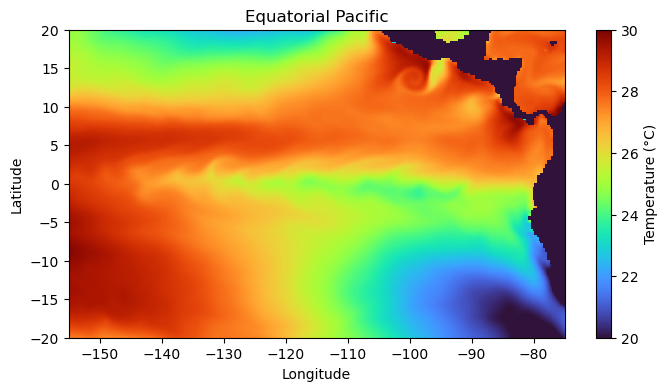

In [8]:
# #make your figure here
subset_sst_flipped = np.flipud(subset_sst)

fig = plt.figure(figsize=(8, 4))

# Display the data
plt.imshow(subset_sst_flipped, cmap='turbo', extent=[min_lon, max_lon, min_lat, max_lat], vmin=20, vmax=30, aspect='auto')

# Add a color bar
plt.colorbar(label='Temperature (°C)')

# Add labels and title
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Equatorial Pacific')

# Show the plot
plt.show()



## Part 3: Formulate a Plotting Function
When you are happy with your plot, make your code into a function that will take the year, month, and day as inputs, and output the figure into a given directory. 

In [9]:
def plot_panel(year,month,day):
    # fill in your function here
    file_name = f"SST_{year}{month:02d}{day:02d}.nc"
    file_path = os.path.join('/Users/surjitsingh/Desktop/CS185C/Data/ECCO/Version5/Alpha/interp_monthly/SST' , file_name)

    if not os.path.exists(file_path):
        print(f"File {file_name} not found!")
        return

    dataset = nc4.Dataset(file_path, mode='r')
    lat = dataset.variables['LATITUDE_T'][:]
    lon = dataset.variables['LONGITUDE_T'][:]
    sst = dataset.variables['SST'][:]

    min_lon, max_lon = -155, -75
    min_lat, max_lat = -20, 20

    min_row = np.abs(latitudes - min_lat).argmin()
    max_row = np.abs(latitudes - max_lat).argmin()
    min_col = np.abs(longitudes - min_lon).argmin()  
    max_col = np.abs(longitudes - max_lon).argmin()

    subset_sst = sst_data[0, min_row:max_row, min_col:max_col]
    subset_sst_flipped = np.flipud(subset_sst)

    plt.figure(figsize = (8, 4))
    plt.imshow(subset_sst_flipped, cmap='turbo', extent=[min_lon, max_lon, min_lat, max_lat], vmin=20, vmax=30, aspect='auto')
    plt.colorbar(label='Temperature (°C)')
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    plt.title(f'Equatorial Pacific SST for {year}')

    output_dir = '/Users/surjitsingh/Desktop/CS185C/Data/output'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    save_path = os.path.join(output_dir, f'sst_plot_{year}{month:02d}{day:02d}.png')
    plt.savefig(save_path)
    plt.close()
    print(f"Saved plot for {year} - {month:02d} - {day:02d} at {save_path} ")

    


Once the function is complete, use it to loop through all of the data to make a plot for each day of the year. The following lines of code will form the panels of a data visualization movie when using daily data. If you are using monthly data, update accordingly:

In [10]:
# loop through the data and make a plot for each day
year = 2003
for month in range(1,13):
    if month in [1,3,5,7,8,10,12]:
        n_days = 31
    elif month in [4,6,9,11]:
        n_days = 30
    else:
        if year%4==0:
            n_days = 29
        else:
            n_days = 28
    for day in range(1,n_days+1):
        plot_panel(year,month,day)

/var/folders/23/zlgrs7_12rl2hkx2zv0v2ll40000gn/T/ipykernel_31624/2947996957.py:13: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  sst = dataset.variables['SST'][:]


Saved plot for 2003 - 01 - 01 at /Users/surjitsingh/Desktop/CS185C/Data/output/sst_plot_20030101.png 
Saved plot for 2003 - 01 - 02 at /Users/surjitsingh/Desktop/CS185C/Data/output/sst_plot_20030102.png 
Saved plot for 2003 - 01 - 03 at /Users/surjitsingh/Desktop/CS185C/Data/output/sst_plot_20030103.png 
Saved plot for 2003 - 01 - 04 at /Users/surjitsingh/Desktop/CS185C/Data/output/sst_plot_20030104.png 
Saved plot for 2003 - 01 - 05 at /Users/surjitsingh/Desktop/CS185C/Data/output/sst_plot_20030105.png 
Saved plot for 2003 - 01 - 06 at /Users/surjitsingh/Desktop/CS185C/Data/output/sst_plot_20030106.png 
Saved plot for 2003 - 01 - 07 at /Users/surjitsingh/Desktop/CS185C/Data/output/sst_plot_20030107.png 
Saved plot for 2003 - 01 - 08 at /Users/surjitsingh/Desktop/CS185C/Data/output/sst_plot_20030108.png 
File SST_20030109.nc not found!
Saved plot for 2003 - 01 - 10 at /Users/surjitsingh/Desktop/CS185C/Data/output/sst_plot_20030110.png 
Saved plot for 2003 - 01 - 11 at /Users/surjitsing

## Part 4: Compile Panels into a Movie
After creating all of the panels, stitch them together into a movie using moviepy:

In [11]:
# make a list of files for each movie panel
import os
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip

output_dir = '/Users/surjitsingh/Desktop/CS185C/Data/output'

# sort the panels
image_files = [os.path.join(output_dir, img) for img in sorted(os.listdir(output_dir)) if img.endswith( '.png')]

In [12]:
# set the frames per second

fps = 15
# use the ImageSequenceClip module to set up the clip
clip = ImageSequenceClip(image_files, fps=fps)

# write the video to a file
output_video_path = '/Users/surjitsingh/Desktop/CS185C/movies.mp4'
clip.write_videofile(output_video_path, codec= 'libx264')

print(f"movie made: {output_video_path}")

Moviepy - Building video /Users/surjitsingh/Desktop/CS185C/movies.mp4.
Moviepy - Writing video /Users/surjitsingh/Desktop/CS185C/movies.mp4



Moviepy - Done !
Moviepy - video ready /Users/surjitsingh/Desktop/CS185C/movies.mp4
movie made: /Users/surjitsingh/Desktop/CS185C/movies.mp4


## Part 5: Interpret Features in the Movie
A movie gives a good visualization of the physical processes occurring in a model. Describe one feature you see in the movie and relate it to an oceanographic feature. It could be a feature discussed in class or another feature you noticed and researched on your own.

Answer: There isn't any movemnt so it may be because it stayed the same 